<a href="https://colab.research.google.com/github/ShreyanshBardia/RepVGG/blob/main/RepVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial

In [ ]:
def conv_bn(in_channels, out_channels,kernel_size,stride,padding):
    conv_bnorm = nn.Sequential()
    conv_bnorm.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, bias=False))
    conv_bnorm.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return conv_bnorm

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.in_channels = in_channels
        if out_channels == in_channels and stride == 1:
            self.identity = nn.BatchNorm2d(num_features=in_channels)
        else:
           self.identity = None
        self.conv_3x3 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=0)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        if self.training:
            if hasattr(self, 'combined_3x3'):    # if training again then need to update inference model
                self.__delattr__('combined_3x3')
            if self.identity is None:
                pass_th = 0
            else:
                pass_th = self.identity(inputs)

            return self.activation(self.conv_3x3(inputs) + self.conv_1x1(inputs) + pass_th)
        else:
            try:
                return self.activation(self.combined_3x3(inputs))
            except:
                self.switch_to_inference()
                return self.activation(self.combined_3x3(inputs))


    def bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.BatchNorm2d):
            input_dim = self.in_channels
            kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
            for i in range(self.in_channels):
                kernel_value[i, i, 1, 1] = 1
            self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def get_equivalent_kernel_bias(self):

        kernel3x3 = torch.ao.quantization.fuse_modules(self.conv_3x3,['conv','bn']).conv
        kernel_weight_3x3, bias_3x3 = kernel3x3.weight, kernel3x3.bias

        kernel1x1 = torch.ao.quantization.fuse_modules(self.conv_1x1,['conv','bn']).conv
        kernel_weight_1x1, bias_1x1 = kernel1x1.weight, kernel1x1.bias
        # kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernel_weight_id, bias_id = self.bn_tensor(self.identity)
        weight = kernel_weight_3x3 + self._pad_1x1_to_3x3_tensor(kernel_weight_1x1) + (kernel_weight_id)
        return weight, bias_3x3 + bias_1x1 + bias_id

    def _pad_1x1_to_3x3_tensor(self, kernel):
        if kernel is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel, [1,1,1,1])


    def switch_to_inference(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        self.combined_3x3 = nn.Conv2d(in_channels=self.conv_3x3.conv.in_channels, out_channels=self.conv_3x3.conv.out_channels,
                                     kernel_size=self.conv_3x3.conv.kernel_size, stride=self.conv_3x3.conv.stride,
                                     padding=self.conv_3x3.conv.padding, bias=True)
        self.combined_3x3.weight.data = kernel
        self.combined_3x3.bias.data = bias



class RepVGG(nn.Module):

    def __init__(self, layers, multiplier, num_classes=1000):
        super().__init__()

        self.in_planes = min(64, int(64 * multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, stride=2)
        self.stage1 = self._make_stage(int(64 * multiplier[0]), layers[0], stride=2)
        self.stage2 = self._make_stage(int(128 * multiplier[1]), layers[1], stride=2)
        self.stage3 = self._make_stage(int(256 * multiplier[2]), layers[2], stride=2)
        self.stage4 = self._make_stage(int(512 * multiplier[3]), layers[3], stride=2)
        self.pooling = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(int(512 * multiplier[3]), num_classes)

    def _make_stage(self, planes, layers, stride):
        strides = [stride] + [1]*(layers-1)
        layer_list = []
        for stride in strides:
            layer_list.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, stride=stride))
            self.in_planes = planes
        return nn.Sequential(*layer_list)

    def forward(self, x):
        output = self.stage0(x)
        for stage in (self.stage1, self.stage2, self.stage3, self.stage4):
            output = stage(output)
        output = self.pooling(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

In [ ]:

def create_RepVGG_A0():
    return RepVGG(layers=[2, 4, 14, 1], num_classes=1000,
                  multiplier=[0.75, 0.75, 0.75, 2.5])

def create_RepVGG_A1():
    return RepVGG(layers=[2, 4, 14, 1], num_classes=1000,
                  multiplier=[1, 1, 1, 2.5])

def create_RepVGG_A2():
    return RepVGG(layers=[2, 4, 14, 1], num_classes=1000,
                  multiplier=[1.5, 1.5, 1.5, 2.75])

def create_RepVGG_B0():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[1, 1, 1, 2.5])

def create_RepVGG_B1():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[2, 2, 2, 4])

def create_RepVGG_B1g2():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy, use_checkpoint=use_checkpoint)

def create_RepVGG_B1g4():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy, use_checkpoint=use_checkpoint)


def create_RepVGG_B2():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[2.5, 2.5, 2.5, 5])

def create_RepVGG_B2g2():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[2.5, 2.5, 2.5, 5])

def create_RepVGG_B2g4():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[2.5, 2.5, 2.5, 5])


def create_RepVGG_B3():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[3, 3, 3, 5])

def create_RepVGG_B3g2():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[3, 3, 3, 5])

def create_RepVGG_B3g4():
    return RepVGG(layers=[4, 6, 16, 1], num_classes=1000,
                  multiplier=[3, 3, 3, 5])

def create_RepVGG_D2se():
    return RepVGG(layers=[8, 14, 24, 1], num_classes=1000,
                  multiplier=[2.5, 2.5, 2.5, 5])


In [ ]:
net=RepVGG(layers=[2, 4, 14, 1], num_classes=10,
                  multiplier=[0.75, 0.75, 0.75, 2.5])

Files already downloaded and verified
Files already downloaded and verified


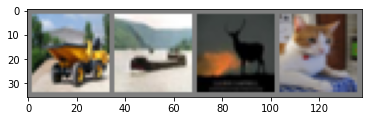

truck ship  deer  cat  
[1,   100] loss: 2.901
[1,   200] loss: 3.119
[1,   300] loss: 2.852
[1,   400] loss: 2.806
[1,   500] loss: 2.826
[1,   600] loss: 2.729
[1,   700] loss: 2.631
[1,   800] loss: 2.655
[1,   900] loss: 2.669
[1,  1000] loss: 2.570
[1,  1100] loss: 2.550


KeyboardInterrupt: ignored

In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

z=0
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        z+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')